# Lab 2: Set Covering with Genetic Algorithms


## Task

Given a number $N$ and some lists of integers $P = (L_0, L_1, L_2, ..., L_n)$,
determine is possible $S = (L_{s_0}, L_{s_1}, L_{s_2}, ..., L_{s_n})$
such that each number between $0$ and $N-1$ appears in at least one list

$$\forall n \in [0, N-1] \ \exists i : n \in L_{s_i}$$

and that the total numbers of elements in all $L_{s_i}$ is minimum.

## THE PROBLEM MUST BE SOLVED WITH GENETIC ALGORITHMS
## DEPENDENCIES

In [832]:
import copy
import random
from matplotlib import pyplot as plt
from collections import namedtuple


PENALTY_THRESHOLD = 1000000000
NUM_GENERATIONS = 100

SEED = 42
Individual = namedtuple("Individual", ["genome", "fitness"])

## Input generator

In [833]:
def problem(N, seed=None):
    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

In [834]:
def goal_test(state):
    return set(sum((e for e in state), start=())) == GOAL

In [835]:
def w(genome):
    if goal_test(genome) is False:
        return -PENALTY_THRESHOLD
    else:
        return -sum([len(i) for i in genome])


def tournament(population, tournament_size=5):
    return max(random.choices(population, k=tournament_size), key=lambda i: (i.fitness, len(i)))


def cross_over(g1, g2, all_lists):
    cut = random.randint(0, min([len(g1), len(g2)]))
    best = g1

    for _ in range(100):
        new = set(g1[:cut] + g2[cut:])
        if len(new) < N:
            pick_one = random.choice(list(set(all_lists) - new))
            new = g1[:cut] + [pick_one] + g2[cut + 1:]
            if w(new) > w(best):
                best = new

    return best

def mutation(g, all_lists):
    point = random.randint(0, len(g) - 1)

    for _ in range(100):
        pick_one = random.choice(list(set(all_lists) - set(g)))
        new = g[:point] + [pick_one] + g[point + 1:]
        if w(new) > w(g):
            return new

    return g

## The following cell contains _unused_ code, please ignore it.

In [836]:
# this function is never used, please ignore it
def find_bloat(g):
    countN = dict()
    for i in g:
        for e in i:
            if countN.get(e) is None:
                countN[e] = 1
            else:
                countN[e] = countN.get(e) + 1

    for i in sorted(g, key=lambda i: -len(i), reverse=True):
        for e, num in enumerate(i):
            if countN[num] == 1:
                break
            elif e + 1 == len(i) and countN[num] > 1:
                return g.index(i)
    return None

# mutation 3 is never used! (just an alternative version)
def mutation3(g, all_lists):
    point = find_bloat(g)
    if point is not None:
        for _ in range(100):
            pick_one = random.choice(list(set(all_lists) - set(g)))
            new = g[:point] + [pick_one] + g[point + 1:]
            if w(new) > w(g):
                return new

    return g

# mutation2 is never used! (just an alternative version)
def mutation2(g, all_lists):
    m = g
    n_mutations = random.choices(population=[1, 2, 3, 4, 5], weights=[0.65, 0.2, 0.09, 0.04, 0.02])


    for _ in range(n_mutations):
        point = random.randint(0, len(g) - 1)

        best = m
        for _ in range(100):
            pick_one = random.choice(list(set(all_lists) - set(m)))
            new = m[:point] + [pick_one] + m[point + 1:]
            if w(new) > w(best):
                best = new

    return best

## First individuals generator

In [837]:
def generate_population(N):
    problem_out = problem(N, SEED)
    all_lists = list(set(tuple(sorted(_)) for _ in problem_out))
    population = list()
    for _ in range(N * 20):
        genome = random.sample(all_lists, random.randint(1, N))
        population.append(Individual(genome, w(genome)))

    return population, all_lists


## Evolutionary Controller

In [838]:
def performance_eval(fitness_log):
    avg_line = [sum(f[1] for f in fitness_log if f[0] == x and f[1] > -1000)/len([f[1] for f in fitness_log if f[0] == x and f[1] > -1000] ) for x in range(NUM_GENERATIONS)]

    gen_best = [max(f[1] for f in fitness_log if f[0] == x) for x in range(NUM_GENERATIONS)]
    plt.figure(figsize=(15, 6))
    plt.plot([x for x, _ in enumerate(gen_best)], [y for _, y in enumerate(gen_best)])
    plt.plot([x for x, _ in enumerate(avg_line)], [y for _, y in enumerate(avg_line)])


In [839]:
import numpy as np

def let_it_grow(N, INITIAL_POPULATION, all_lists, performance_flag=False):
    POPULATION = copy.deepcopy(INITIAL_POPULATION)
    best = Individual([], -PENALTY_THRESHOLD)
    fitness_log = [(0, i.fitness) for i in POPULATION]
    offspring_size = int(np.round(2*np.log2(10)))

    optim_flag = False
    for g in range(NUM_GENERATIONS):
        offspring = list()
        for i in range(offspring_size):
            if random.random() < 0.3:
                p = tournament(POPULATION)
                o = mutation(p.genome, all_lists)
            else:
                p1 = tournament(POPULATION)
                p2 = tournament(POPULATION)
                o = cross_over(p1.genome, p2.genome, all_lists)
            f = w(o)
            fitness_log.append((g, f))
            offspring.append(Individual(o, f))
        POPULATION += offspring
        POPULATION = sorted(POPULATION, key=lambda i: i.fitness, reverse=True)[:N]
        if POPULATION[0].fitness > best.fitness:
            best = POPULATION[0]
    if optim_flag is not True:
        print(f"solution: {best.genome}")
        print(f"total cost: {-best.fitness}")

    if performance_flag is True:
        performance_eval(fitness_log)

## Script

Searching solution for N = 5
solution: [(2, 3), (0,), (4,), (1,)]
total cost: 5
------------------------------------------------------------
Searching solution for N = 10
solution: [(2, 5, 7), (3, 9), (0, 4), (1, 6, 8)]
total cost: 10
------------------------------------------------------------
Searching solution for N = 20
solution: [(2, 15, 18), (4, 7, 11, 12, 15, 16, 18), (6, 9, 16, 19), (0, 3, 5, 8, 9, 10, 13, 14, 17), (1, 3, 4, 5)]
total cost: 27
------------------------------------------------------------
Searching solution for N = 100
solution: [(3, 4, 11, 13, 17, 27, 28, 29, 31, 35, 54, 64, 69, 71, 75, 77, 86, 94), (0, 4, 19, 34, 42, 49, 50, 61, 62, 63, 65, 73, 81, 83, 85, 89, 90, 98), (1, 12, 29, 37, 43, 48, 49, 51, 52, 54, 58, 59, 76, 79, 83, 84, 96), (0, 7, 11, 16, 20, 21, 26, 35, 40, 51, 54, 55, 57, 61, 62, 73, 78, 81, 97, 99), (2, 7, 12, 20, 27, 32, 33, 42, 44, 46, 50, 57, 60, 71, 80, 88, 95), (10, 11, 16, 25, 39, 42, 45, 57, 59, 68, 72, 75, 76, 78, 80, 85, 88, 89, 90, 91,

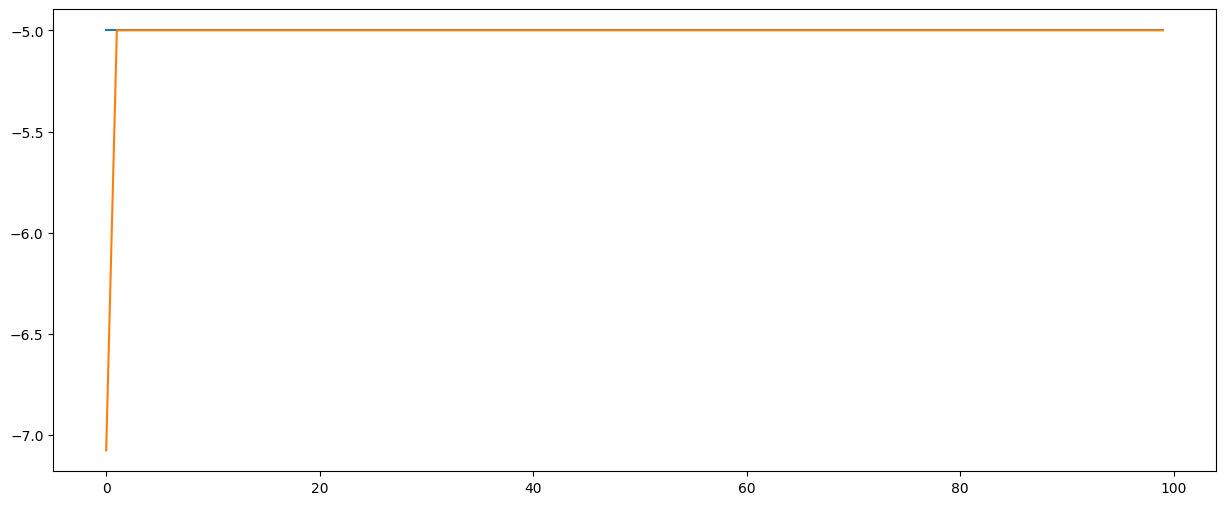

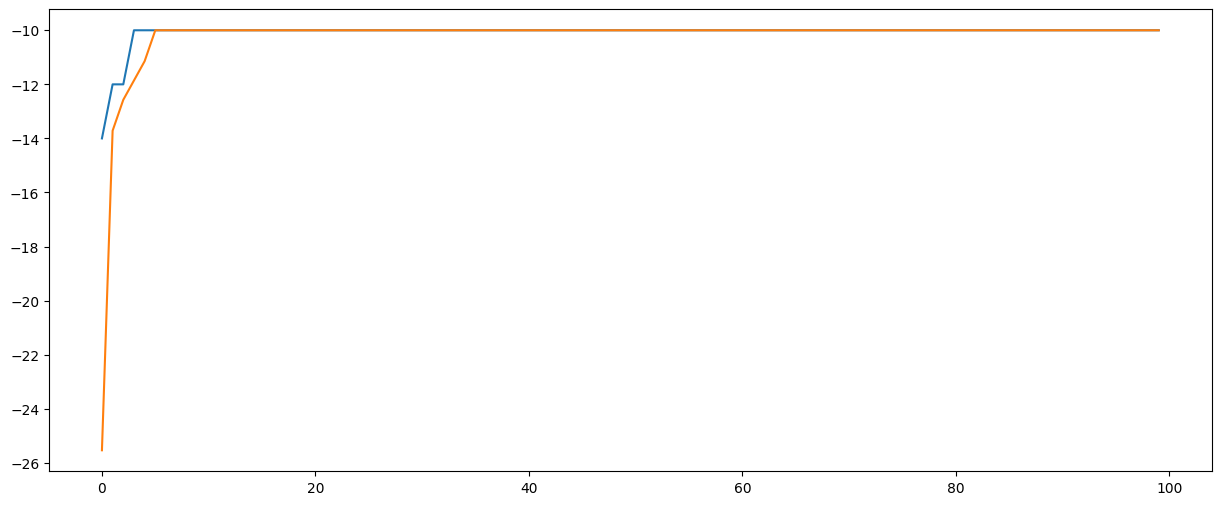

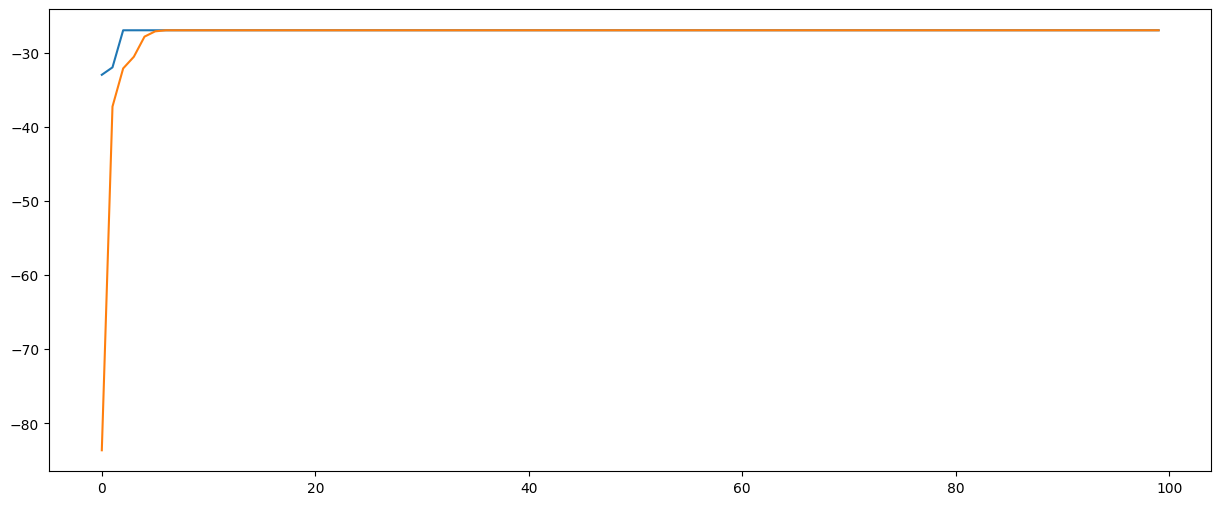

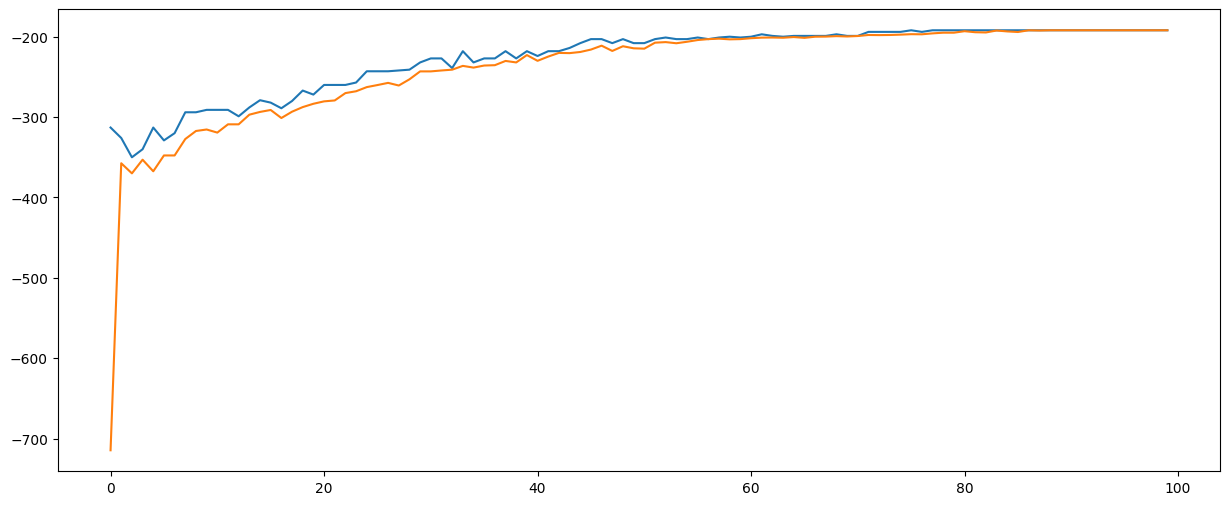

In [840]:
for N in [5, 10, 20, 100]:
    GOAL = set(range(N))
    INITIAL_POPULATION, all_lists = generate_population(N)

    print(f"Searching solution for N = {N}")
    let_it_grow(N, INITIAL_POPULATION, all_lists, performance_flag=True)
    print("------------------------------------------------------------")